In [2]:
library(aod)
data(mtcars)

In [4]:
model <- lm(mpg ~ disp + carb + hp + cyl, data = mtcars)
summary(model)


Call:
lm(formula = mpg ~ disp + carb + hp + cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0761 -1.5752 -0.2051  1.0745  6.3047 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 34.021595   2.523397  13.482 1.65e-13 ***
disp        -0.026906   0.011309  -2.379   0.0247 *  
carb        -0.926863   0.578882  -1.601   0.1210    
hp           0.009349   0.020701   0.452   0.6551    
cyl         -1.048523   0.783910  -1.338   0.1922    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.973 on 27 degrees of freedom
Multiple R-squared:  0.788,	Adjusted R-squared:  0.7566 
F-statistic: 25.09 on 4 and 27 DF,  p-value: 9.354e-09


In [6]:
wald.test(Sigma = vcov(model), b = coef(model), Terms = 3)

Wald test:
----------

Chi-squared test:
X2 = 2.6, df = 1, P(> X2) = 0.11

In [15]:
#---------------------------------------------------------------------------
#TODO: 根据单个SNP的LD scored对SNPs进行聚簇
#---------------------------------------------------------------------------
lds_seg = read.table("Partition_Genetic/20DPA/20DPA_Dt.score.ld",header=T,colClasses=c("character",rep("numeric",8)))
quartiles=summary(lds_seg$ldscore_SNP)
lb1 = which(lds_seg$ldscore_SNP <= quartiles[2])
lb2 = which(lds_seg$ldscore_SNP > quartiles[2] & lds_seg$ldscore_SNP <= quartiles[3])
lb3 = which(lds_seg$ldscore_SNP > quartiles[3] & lds_seg$ldscore_SNP <= quartiles[5])
lb4 = which(lds_seg$ldscore_SNP > quartiles[5])
lb1_snp = lds_seg$SNP[lb1]
lb2_snp = lds_seg$SNP[lb2]
lb3_snp = lds_seg$SNP[lb3]
lb4_snp = lds_seg$SNP[lb4]
write.table(lb1_snp, "Partition_Genetic/20DPA/20DPA_Dt_snp_group1.txt", row.names=F, quote=F, col.names=F)
write.table(lb2_snp, "Partition_Genetic/20DPA/20DPA_Dt_snp_group2.txt", row.names=F, quote=F, col.names=F)
write.table(lb3_snp, "Partition_Genetic/20DPA/20DPA_Dt_snp_group3.txt", row.names=F, quote=F, col.names=F)
write.table(lb4_snp, "Partition_Genetic/20DPA/20DPA_Dt_snp_group4.txt", row.names=F, quote=F, col.names=F)

In [1]:
library(dplyr)
library(tidyr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
#--------------------------------------------------------
#TODO: 比较eGene和SNP所在的基因组间的关系
#--------------------------------------------------------
data=read.table("./8DPA/Partition_Genetic_HomoeologGene_V2",header=T)
pivotData=data %>% select(c("eGene","AtRatio","DtRatio")) %>% pivot_longer(
    cols =c("AtRatio","DtRatio"),
    names_to="sub_genome",
    values_to = "VariantRatio"
)
pivotData$eGene=as.character(pivotData$eGene)
getSubgenome=function(x){
    if(startsWith(x,"Ghir_A")){
        return("At_gene")
    }else{
        return("Dt_gene")
    }
}
pivotData$eGene2=as.character(lapply(pivotData$eGene,getSubgenome))

In [6]:
pivotData %>%
    filter(eGene2 == "At_gene" & sub_genome == "DtRatio") %>%
    select(VariantRatio) %>%
    apply(2, median)
pivotData %>%
    filter(eGene2 == "Dt_gene" & sub_genome == "AtRatio") %>%
    select(VariantRatio) %>%
    apply(2, median)    

VariantRatio 
   0.0457184

VariantRatio 
  0.04229854

In [7]:
head(pivotData)

eGene,sub_genome,VariantRatio,eGene2
<chr>,<chr>,<dbl>,<chr>
Ghir_A01G000070,AtRatio,0.004217831,At_gene
Ghir_A01G000070,DtRatio,0.054810116,At_gene
Ghir_A01G000170,AtRatio,0.036865120,At_gene
Ghir_A01G000170,DtRatio,0.069072373,At_gene
Ghir_A01G000270,AtRatio,0.066840693,At_gene
Ghir_A01G000270,DtRatio,0.017379404,At_gene


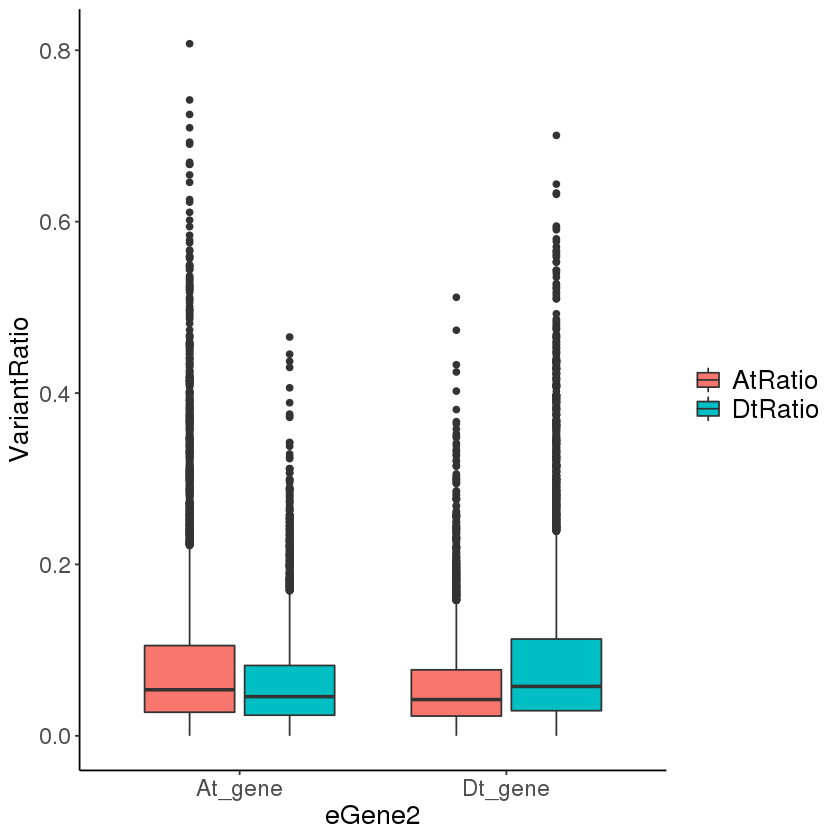

In [8]:
p <- ggplot(pivotData, aes(x = eGene2, y = VariantRatio)) +
    geom_boxplot(aes(fill = sub_genome)) +
    theme_classic() +
    theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 16),
        legend.title = element_blank()
    )
#svg("geneVariant_Partition.svg")    
#print(p)
#dev.off()
p

In [40]:
a=pivotData %>% filter(eGene2=="Dt_gene" &  sub_genome=='AtRatio')
b=pivotData %>% filter(eGene2=="Dt_gene" &  sub_genome=='DtRatio')
wilcox.test(a$VariantRatio,b$VariantRatio,paired=T)


	Wilcoxon signed rank test with continuity correction

data:  a$VariantRatio and b$VariantRatio
V = 7199362, p-value = 9.805e-05
alternative hypothesis: true location shift is not equal to 0


In [2]:
#--------------------------------------------------------
#TODO 采样LDAK计算得到的结果
#--------------------------------------------------------
data=read.table("./0DPA/Partition_eGene_LDAK.txt",header=T)

for(stage in c("4DPA","8DPA","12DPA","16DPA","20DPA")){
    tmp=read.table(paste(stage,"Partition_eGene_LDAK.txt",sep="/"),header = T)
    data=rbind(data,tmp)
}
pivotData=data %>% filter(converged=="YES") %>% 
    select(c("GeneID","At","Dt")) %>% pivot_longer(
    cols =c("At","Dt"),
    names_to="sub_genome",
    values_to = "VariantRatio"
)
pivotData$GeneID=as.character(pivotData$GeneID)
getSubgenome=function(x){
    if(startsWith(x,"Ghir_A")){
        return("At_gene")
    }else{
        return("Dt_gene")
    }
}
pivotData$GeneID2=as.character(lapply(pivotData$GeneID,getSubgenome))
pivotData=pivotData %>% mutate(VariantRatio=ifelse(VariantRatio<0 ,0,VariantRatio))
dim(pivotData)

[1] 116946      4

In [3]:
head(data %>% filter(converged =="YES"))

,GeneID,At,At_se,Dt,Dt_se,converged,different
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,Ghir_A01G000330,0.000000,0.079035,0.199440,0.113424,YES,-0.199440
2,Ghir_A01G000390,0.319296,0.144561,0.070240,0.113197,YES,0.249056
3,Ghir_A01G000400,0.068812,0.110394,0.352062,0.116745,YES,-0.283250
4,Ghir_A01G000490,0.000000,0.077893,0.157708,0.108775,YES,-0.157708
5,Ghir_A01G000550,0.162595,0.126381,0.032433,0.095751,YES,0.130162
6,Ghir_A01G000700,0.368436,0.144577,0.000000,0.063861,YES,0.368436


In [7]:
pivotData %>% filter(
        GeneID2=="Dt_gene"
    )%>% count(
            sub_genome
    )

sub_genome,n
<chr>,<int>
At,29791
Dt,29791


png 
  2

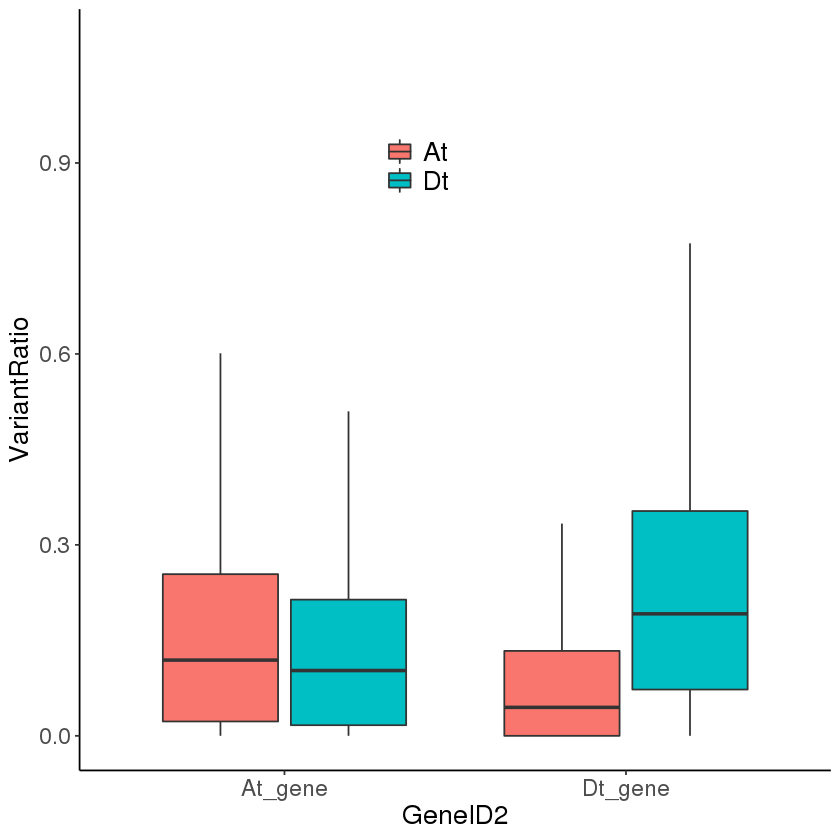

In [11]:
p <- pivotData %>% ggplot(aes(x = GeneID2, y = VariantRatio)) +
    geom_boxplot(aes(fill = sub_genome),outlier.colour = NA) +
    theme_classic() +
    theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 16),
        legend.title = element_blank(),
        legend.position = c(0.45,0.8)
    )
pdf("geneVariant_Partition.pdf")
print(p)
dev.off()
p

In [8]:
a=pivotData %>% filter(GeneID2=="Dt_gene" &  sub_genome=='At')
b=pivotData %>% filter(GeneID2=="Dt_gene" &  sub_genome=='Dt')
wilcox.test(a$VariantRatio,b$VariantRatio,paired=T)


	Wilcoxon signed rank test with continuity correction

data:  a$VariantRatio and b$VariantRatio
V = 82772901, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [5]:
#----------------------------------------------
#* 亚组遗传力解构后的差值
#----------------------------------------------
At_genetic=data[grep("^Ghir_A",data$GeneID),]
At_genetic$genome='At'
Dt_genetic=data[grep("^Ghir_D",data$GeneID),]
Dt_genetic$genome='Dt'
plotData=rbind(
    At_genetic,Dt_genetic
)


Warning message:
“Removed 43 rows containing non-finite values (stat_density).”


png 
  2

Warning message:
“Removed 43 rows containing non-finite values (stat_density).”


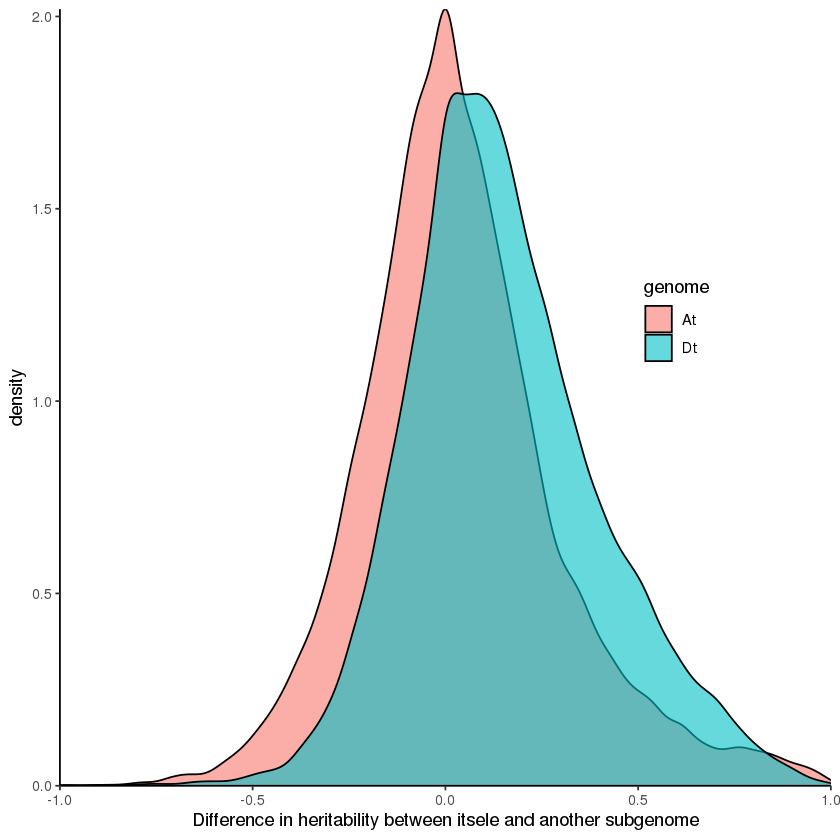

In [12]:
p <- plotData %>% ggplot(aes(x = different, fill = genome)) +
    geom_density(
        alpha = 0.6
    ) +
    theme_classic() +
    theme(legend.position = c(0.8, 0.6)) +
    scale_x_continuous(expand = c(0, 0), limits = c(-1, 1)) +
    scale_y_continuous(expand = c(0, 0)) +
    xlab(
        "Difference in heritability between itsele and another subgenome"
    )
pdf("Genetic_different.pdf")
print(p)
dev.off()
p

In [26]:
max(At_genetic$different)

[1] 1.087357

In [124]:
#--------------------------------------------------------------------
#TODO: 每个基因总的解释力范围;eGene分A和D
#--------------------------------------------------------------------
data=read.table("./0DPA/Partition_Genetic_HomoeologGene",header=T)
totalVariant=data %>% mutate(totalVariant=AtRatio+DtRatio)
totalVariant$eGene=as.character(totalVariant$eGene)
totalVariant$eGene2=as.character(lapply(totalVariant$eGene,getSubgenome))
totalVariant$stage="0DPA"
for(stage in c('4DPA','8DPA','12DPA','16DPA','20DPA')){
    data1=read.table(paste(stage,"Partition_Genetic_HomoeologGene",sep="/"),header=T)
    totalVariant1=data1 %>% mutate(totalVariant=AtRatio+DtRatio)
    totalVariant1$eGene=as.character(totalVariant1$eGene)
    totalVariant1$eGene2=as.character(lapply(totalVariant1$eGene,getSubgenome)) 
    totalVariant1$stage=stage
    totalVariant=rbind(totalVariant,totalVariant1)
}

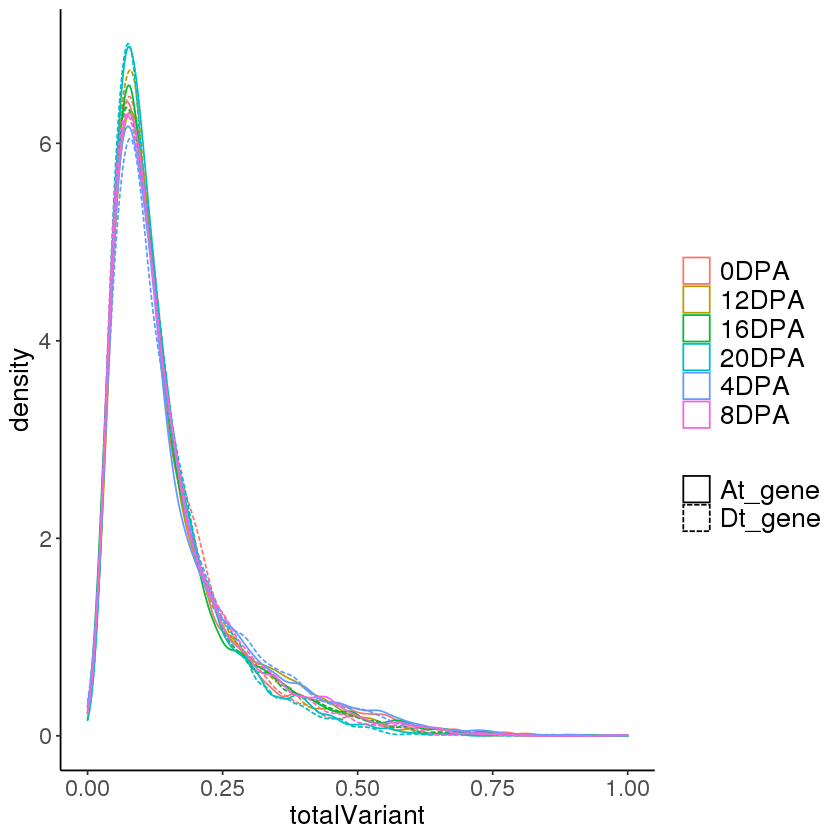

In [70]:
ggplot(totalVariant, aes(x = totalVariant,color=stage,linetype=eGene2)) +
    geom_density() +
    xlim(c(0, 1))+
    theme_classic()+
    theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text=element_text(size = 16),
        legend.title = element_blank()
    )

In [72]:
#----------------------------------------------------
# TODO 每个亚组的SNP解释表达变异是否存在差异
#----------------------------------------------------
data <- read.table("./0DPA/Partition_Genetic_HomoeologGene", header = T)
pivotData <- data %>%
    select(c("eGene", "AtRatio", "DtRatio")) %>%
    pivot_longer(
        cols = c("AtRatio", "DtRatio"),
        names_to = "sub_genome",
        values_to = "VariantRatio"
    )
pivotData$stage <- "0DPA"

for (stage in c("4DPA", "8DPA", "12DPA", "16DPA", "20DPA")) {
    data1 <- read.table(paste(stage, "Partition_Genetic_HomoeologGene", sep = "/"), header = T)
    pivotData1 <- data1 %>%
        select(c("eGene", "AtRatio", "DtRatio")) %>%
        pivot_longer(
            cols = c("AtRatio", "DtRatio"),
            names_to = "sub_genome",
            values_to = "VariantRatio"
        )
    pivotData1$stage <- stage
    pivotData=rbind(pivotData,pivotData1)
}

In [89]:
tmp1=pivotData %>% filter(sub_genome == "AtRatio") %>% select(VariantRatio)
tmp2=pivotData %>% filter(sub_genome == "DtRatio") %>% select(VariantRatio)
wilcox.test(
    tmp1$VariantRatio,
    tmp2$VariantRatio
)


	Wilcoxon rank sum test with continuity correction

data:  tmp1$VariantRatio and tmp2$VariantRatio
W = 1798546388, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


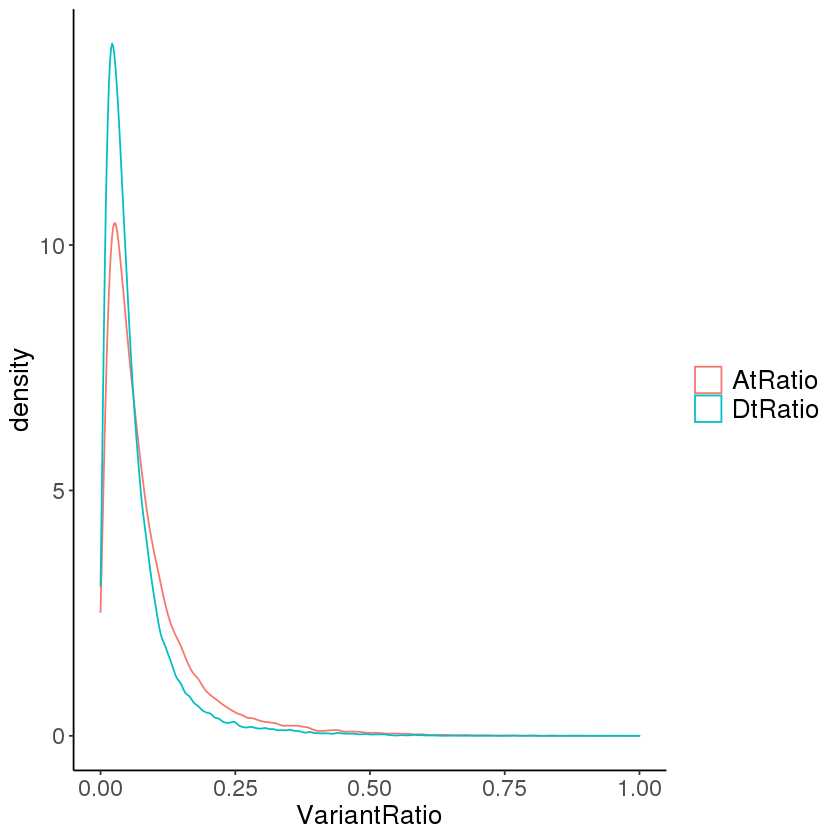

In [75]:
ggplot(pivotData, aes(x = VariantRatio, color = sub_genome)) +
    geom_density() +
    xlim(c(0, 1)) +
    theme_classic() +
    theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        legend.text = element_text(size = 16),
        legend.title = element_blank()
    )

In [145]:
#--------------------------------------------------------------------
#TODO: 在6个时期中收敛的eGene中，随着所有SNP解释率的增加；
#* cis-genomic SNP解释率的变化倍数显著的增加；并且高于trans-genomic SNP
#--------------------------------------------------------------------
start=0.6
end=1

tmmpData_At=totalVariant %>% filter(totalVariant>=start & totalVariant<end & startsWith(eGene,"Ghir_A"))
tmmpData_Dt=totalVariant %>% filter(totalVariant>=start & totalVariant<end & startsWith(eGene,"Ghir_D"))

tmmpData_At=tmmpData_At %>% select(c("eGene","AtRatio","DtRatio","totalVariant")) %>% pivot_longer(
    cols =c("AtRatio","DtRatio"),
    names_to="sub_genome",
    values_to = "VariantRatio"
)
tmmpData_Dt=tmmpData_Dt %>% select(c("eGene","AtRatio","DtRatio","totalVariant")) %>% pivot_longer(
    cols =c("AtRatio","DtRatio"),
    names_to="sub_genome",
    values_to = "VariantRatio"
)
At_gene=function(x){
    if(x=='AtRatio'){
        return("cis")
    }else{
        return("trans")
    }
}
Dt_gene=function(x){
    if(x=='DtRatio'){
        return("cis")
    }else{
        return("trans")
    }
}
tmmpData_At$SNPType=as.character(lapply(tmmpData_At$sub_genome,At_gene))
tmmpData_Dt$SNPType=as.character(lapply(tmmpData_Dt$sub_genome,Dt_gene))
MergeData=rbind(tmmpData_At,tmmpData_Dt)
#* 这些基因在cis-genomic和trans-genomic解释率
MergeData %>% filter(SNPType=="cis") %>% select(VariantRatio) %>% lapply(mean)
MergeData %>% filter(SNPType=="trans") %>% select(VariantRatio) %>% lapply(mean)
#* 6个时期的基因总数
print(length(unique(MergeData$eGene)))

$VariantRatio
[1] 0.5371739

$VariantRatio
[1] 0.1503091

[1] 288


In [93]:
plotData <- data.frame(
    VariationRatio = c(0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6),
    averageCis = c(0.03823, 0.073, 0.139, 0.2195, 0.3114, 0.40447430, 0.5371),
    averaveTrans = c(0.03683, 0.0668, 0.10380, 0.1254, 0.1330, 0.138713, 0.1503),
    geneCount = c(13481, 14217, 5391, 2511, 1256, 599, 288)
)
plotData$rank=rank(plotData$VariationRatio)
plotData=plotData %>% pivot_longer(
    cols = c("averageCis","averaveTrans"),
    names_to = "VariantType",
    values_to = 'VariantRatio'
)

png 
  2

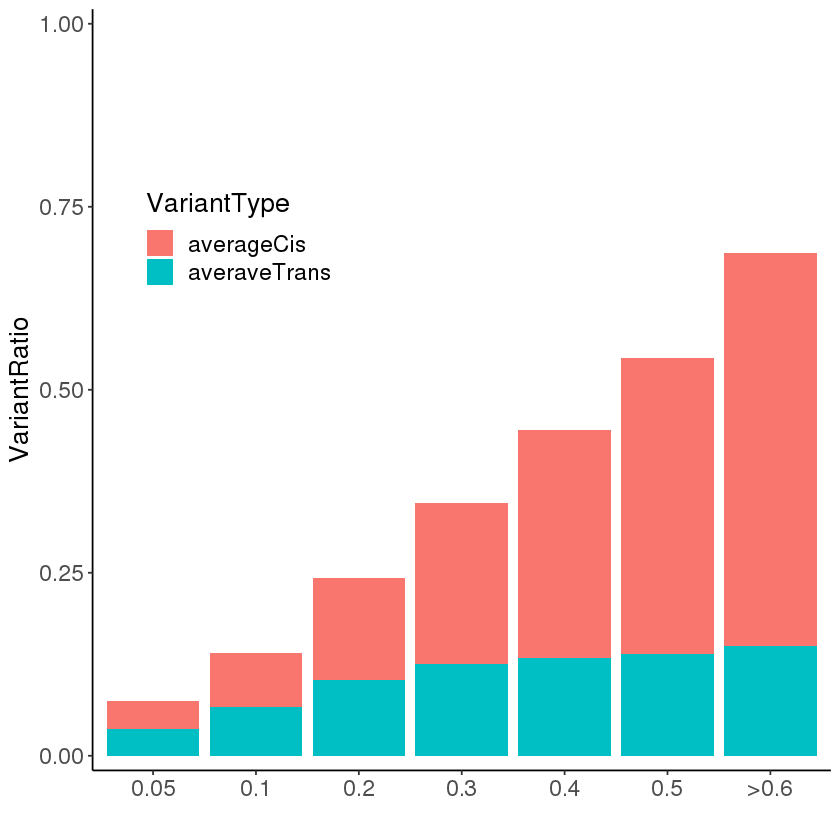

In [94]:
#! 基因表达主要受同一个基因组内的调控元件所调控
p <- ggplot(
    plotData, aes(x = rank, y = VariantRatio, fill = VariantType)
) +
    geom_bar(stat = "identity") +
    theme_classic() +
    theme(
        legend.position = c(0.2, 0.7),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        axis.text = element_text(size = 14)
    ) +
    scale_x_continuous(
        expand = c(0.02, 0),
        breaks = seq(1, 7),
        labels = c("0.05", "0.1", "0.2", "0.3", "0.4", "0.5", ">0.6")
    ) +
    scale_y_continuous(expand = c(0.02, 0), limits = c(0, 1)) +
    xlab("")
svg("GeneticVar_expressionCor.svg")    
print(p)
dev.off()
p

In [1]:
#-----------------------------------------------------------
#* 个体间的遗传差异，导致了Bias的产生
#* 模式图
#-----------------------------------------------------------
library(ggplot2)
library(dplyr)
data=read.table("./Homoeolog_expression_pattern_partBias.txt",header=T)
set.seed(100)
BiasNData <- data %>%
    filter(Bias == "BiasN") %>%
    sample_n(200)

BiasData <-  data %>%
    filter(Bias == "Bias") %>%
    sample_n(80)
plotData=rbind(BiasNData,BiasData)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




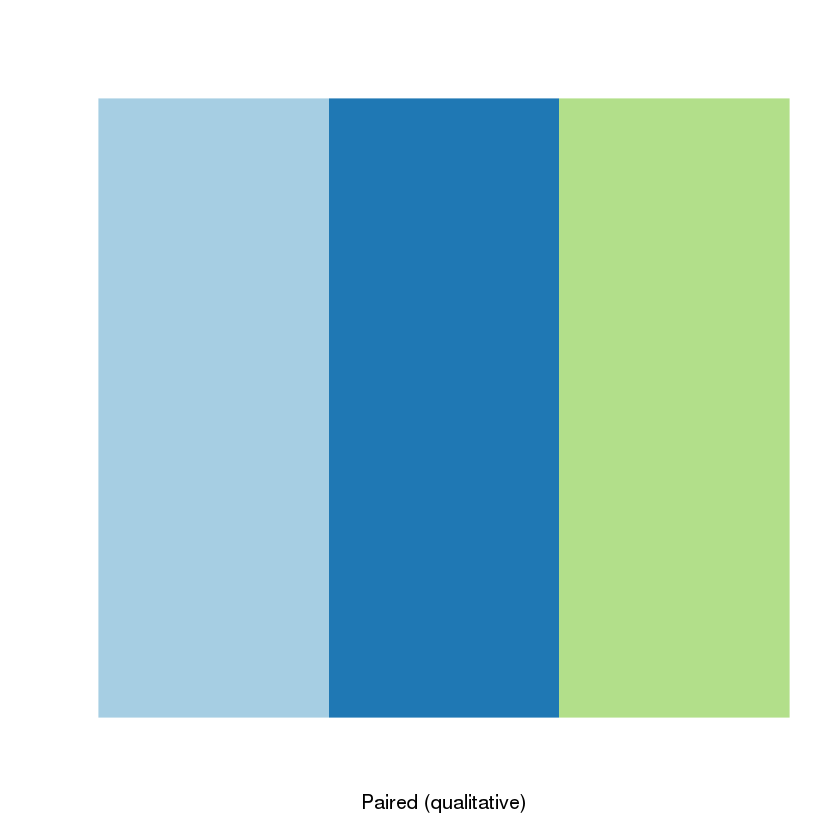

In [2]:
library(RColorBrewer)
display.brewer.pal(3,"Paired")

Warning message:
“Removed 37 rows containing missing values (geom_point).”


png 
  2

Warning message:
“Removed 37 rows containing missing values (geom_point).”


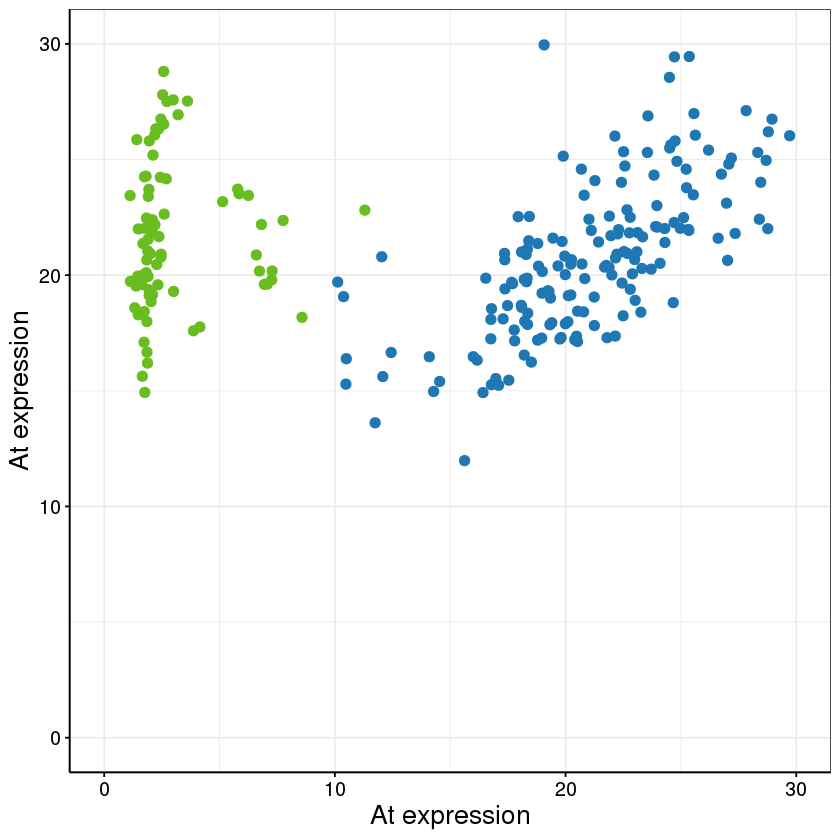

In [5]:
p <- ggplot(
    plotData, aes(x = At, y = Dt, color = Bias)
) +
    geom_point(size = 2.5) +
    xlim(c(0, 30)) +
    ylim(c(0, 30)) +
    theme_bw() +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16),
        legend.position = 'none'
    ) +
    
    scale_color_manual(
        values = c("#69bd20", "#1F78B4")
    ) +
    xlab("At expression") +
    ylab("At expression") +
    base_theme

svg("Homoeolog_Bias_pattern.pdf")
print(p)
dev.off()
p

Warning message:
“Removed 37 rows containing missing values (geom_point).”


png 
  2

Warning message:
“Removed 37 rows containing missing values (geom_point).”


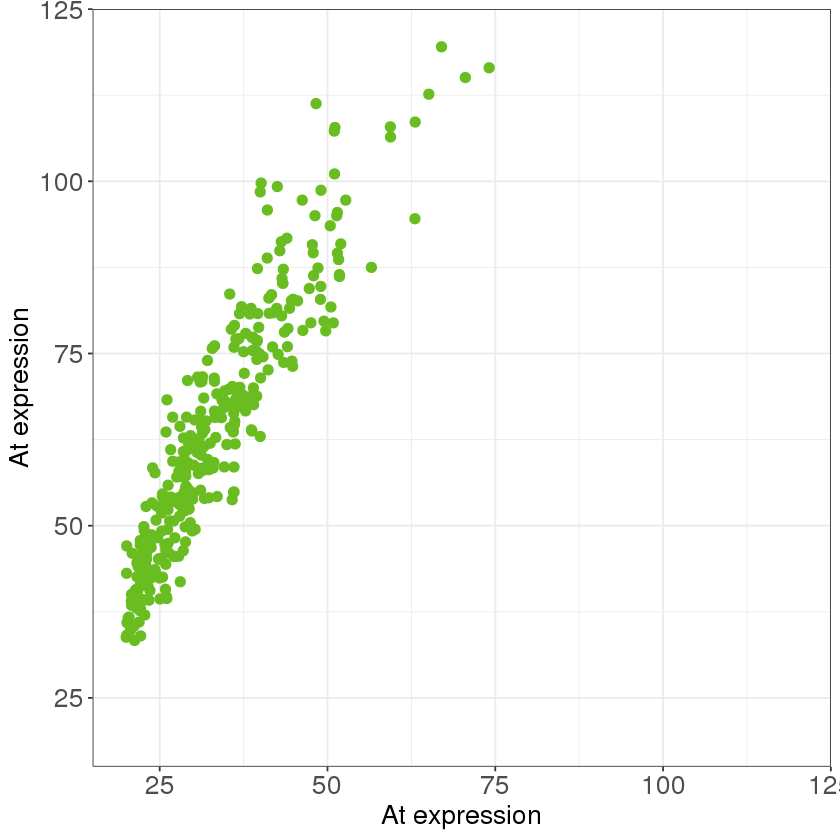

In [97]:
#-----------------------------------
# TODO 完全Bias的样本，A和D的共表达系数
#-----------------------------------
data <- read.table("./Homoeolog_expression_pattern_completeBias.txt", header = T)
p <- ggplot(
    data, aes(x = At, y = Dt, )
) +
    geom_point(size = 2.5, color = "#69bd20") +
    theme_bw() +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16)
    ) +
    # scale_color_manual(
    #     values = c("","#1F78B4")
    # )+
    xlim(c(20, 120)) +
    ylim(c(20, 120)) +
    xlab("At expression") +
    ylab("At expression")

svg("Homoeolog_AllBias_pattern.svg")
print(p)
dev.off()
p

Warning message:
“Removed 2 rows containing missing values (geom_point).”


png 
  2

Warning message:
“Removed 2 rows containing missing values (geom_point).”


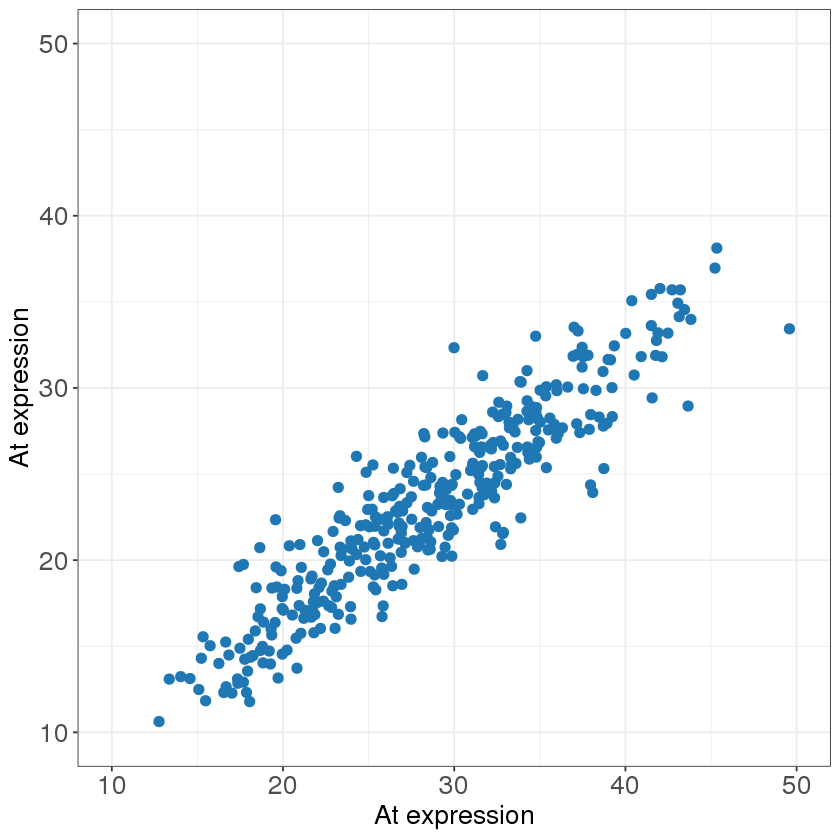

In [98]:
#-----------------------------------
# TODO 完全Bias的样本，A和D的共表达系数
#-----------------------------------
data <- read.table("./Homoeolog_expression_pattern_completeBiasN.txt", header = T)
p=ggplot(
    data, aes(x = At, y = Dt, )
) +
    geom_point(size = 2.5, color = "#1F78B4") +
    theme_bw() +
    theme(
        axis.text = element_text(size = 16),
        axis.title = element_text(size = 16)
    ) +
    # scale_color_manual(
    #     values = c("","#1F78B4")
    # )+
    xlim(c(10, 50)) +
    ylim(c(10, 50)) +
    xlab("At expression") +
    ylab("At expression")

svg("Homoeolog_BiasN_pattern.svg")
print(p)
dev.off()
p